In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# Preprocessing a Whole Slide Image

In this section, we will walk you through a general workflow on how to process WSI using LazySlide.

## `wsiata`
In LazySlide, we mainly work with `wsidata`, which is a data container for:
1. An WSI reader
2. A `SpatialData` object

You don't need to understand the `wsidata` for this tutorial. If you are interested, you can refer to the [Using WSIData]() for details.

## import

The convention namespace for lazyslide is always `zs`.

In [3]:
from wsidata import open_wsi
import lazyslide as zs

## Open a WSI

You can load a WSI either from **local** file or **remote URL** (http, ssh, s3, gcp), here we load a Esophagus slide from GTEx.

In [7]:
wsi = open_wsi("https://brd.nci.nih.gov/brd/imagedownload/GTEX-1117F-1626", reader="tiffslide")

## What's in the wsi?

In [8]:
wsi

WSI: GTEX-1117F-1626
Reader: tiffslide
SpatialData object
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1439, 1696)
└── Tables
      └── 'slide_properties': AnnData (0, 0)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images)

Let's check the slide metadata, this is a slide scan at 20X (magnification) with a mpp (micro per pixel) of 0.4942, it's shape is 40553 * 47807

In [9]:
wsi.properties

SlideProperties(shape=[40553, 47807], n_level=3, level_shape=[[40553, 47807], [10138, 11951], [2534, 2987]], level_downsample=[1.0, 4.0001748319017985, 16.004286728943022], mpp=0.4942, magnification=20.0, bounds=[0, 0, 40553, 47807])

We can first take a quick look at slide, what does it look like.

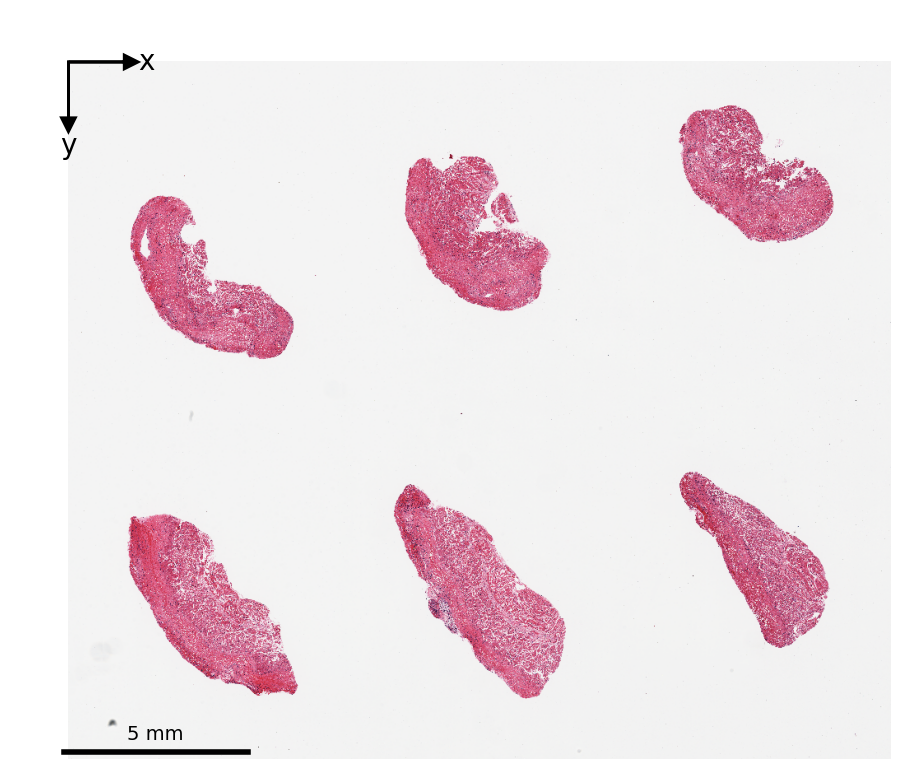

In [10]:
zs.pl.tissue(wsi)

## Tissue Segmentation

Before we proceed to other analysis, we need to segment the tissue from the slide.

We can take a quick look of the segmentation result, the <span style="color: green;">greens</span> are the tissue borders, the <span style="color: blue;">blues</span> are the holes that will be excluded.

The default parameters ususally works pretty well, but you may go ahead to adjust some parameters to fit your need.

In [12]:
zs.pp.find_tissues(wsi)
wsi

WSI: GTEX-1117F-1626
Reader: tiffslide
SpatialData object
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1439, 1696)
├── Shapes
│     └── 'tissues': GeoDataFrame shape: (6, 2) (2D shapes)
└── Tables
      └── 'slide_properties': AnnData (0, 0)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tissues (Shapes)

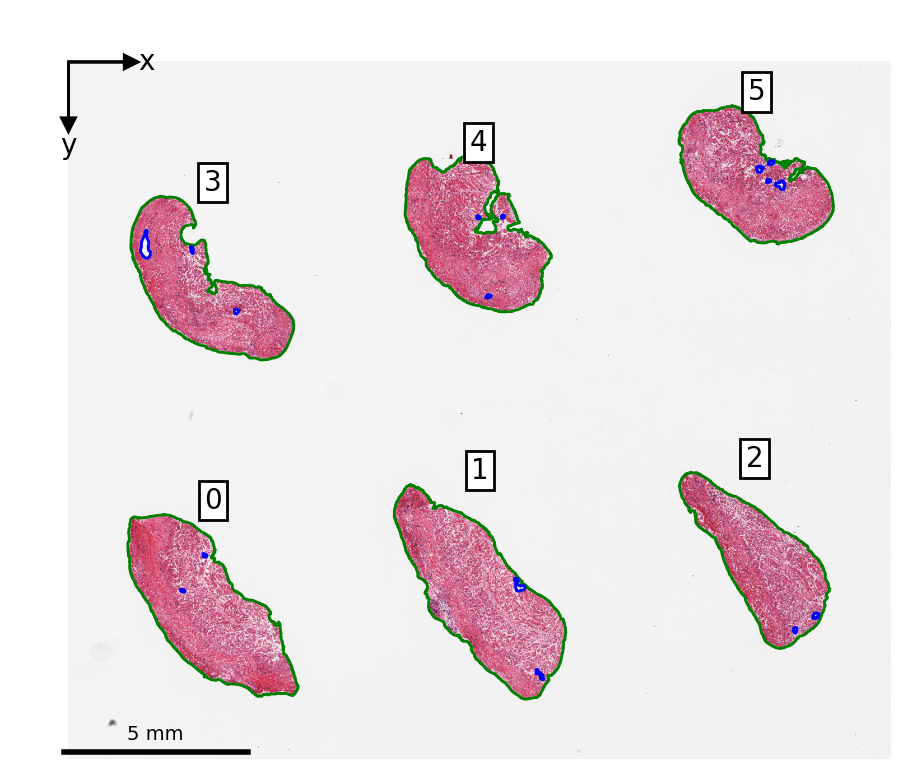

In [13]:
zs.pl.tissue(wsi)

We can also take a detail look on a specific tissue instance.

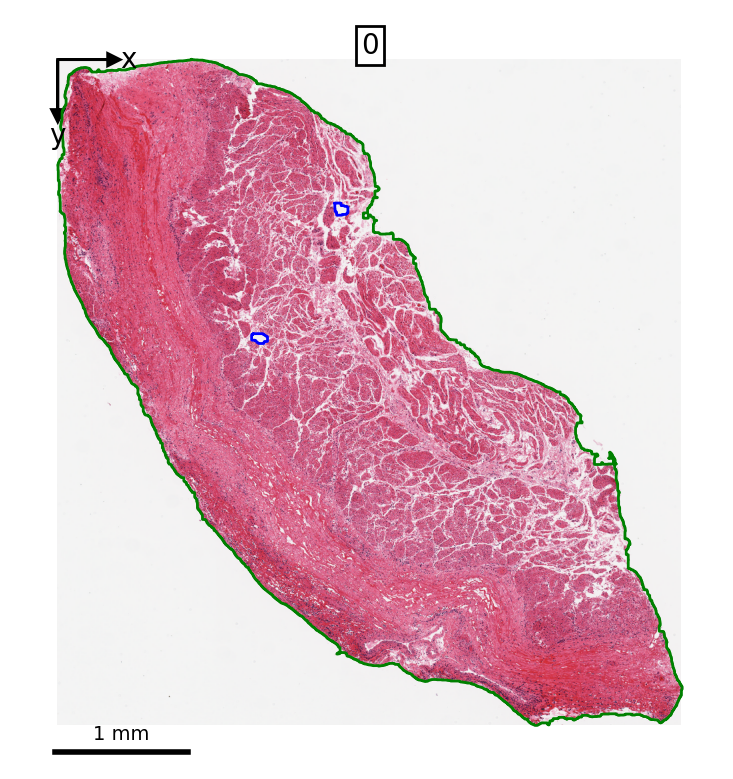

In [14]:
zs.pl.tissue(wsi, tissue_id=0)

## Tissue QC

In [17]:
zs.pp.tissues_qc(wsi, scores=["brightness", "redness"])

## Tissue properties

You can quickly get the geometry properties of each tissue instances.

In [18]:
zs.tl.tissue_props(wsi)

In [19]:
wsi['tissues']

tissue_id                                           geometry  brightness  \
0          0  POLYGON ((5568.243 26317.15, 5564.243 26321.15...  196.855273   
1          1  POLYGON ((19868.868 24585.075, 19864.868 24589...  204.560079   
2          2  POLYGON ((36193.582 23869.043, 36189.582 23873...  201.314285   
3          3  POLYGON ((5368.235 7816.342, 5364.234 7820.342...  199.763826   
4          4  POLYGON ((23381.022 5516.241, 23377.022 5520.2...  186.069382   
5          5  POLYGON ((38569.686 2560.112, 38565.686 2564.1...  188.910463   

      redness    qc        area  area_filled  convex_area  solidity  \
0  225.397795  True  55813624.0   55876024.0   60348752.0  0.924851   
1  227.045672  True  58927954.0   59207554.0   63235394.0  0.931882   
2  223.165962  True  40243496.0   40385136.0   43085112.0  0.934046   
3  225.829961  True  43984368.0   44621920.0   52559304.0  0.836852   
4  220.263375  True  48905928.0   49009496.0   54126856.0  0.903543   
5  218.999074  True  43610648.0   43966864.0   48052216.0  0.907568   

   convexity  ...   moment-mu21   moment-mu12   moment-mu03  moment-nu20  \
0   1.081255  ...  9.565663e+16 -1.171737e+15 -1.268680e+17     0.103677   
1   1.073097  ... -1.121059e+17 -1.614819e+17 -1.183246e+17     0.102320   
2   1.070611  ... -1.702804e+17 -1.629016e+17 -2.948234e+16     0.105309   
3   1.194954  ...  7.767924e+16 -9.549410e+16 -2.658861e+17     0.132992   
4   1.106755  ...  2.614379e+16  9.652588e+15 -5.866457e+16     0.084555   
5   1.101846  ...  1.469983e+16 -4.313919e+16 -6.820582e+16     0.113678   

   moment-nu11  moment-nu02  moment-nu30  moment-nu21  moment-nu12  \
0     0.083833     0.132490     0.005755     0.004099    -0.000050   
1     0.090523     0.145458    -0.000447    -0.004156    -0.005987   
2     0.089518     0.149082    -0.009269    -0.016429    -0.015717   
3     0.091120     0.129258     0.017374     0.005840    -0.007180   
4     0.044155     0.108576     0.002124     0.001555     0.000574   
5     0.053510     0.088094     0.007878     0.001147    -0.003366   

   moment-nu03  
0    -0.005436  
1    -0.004387  
2    -0.002845  
3    -0.019991  
4    -0.003489  
5    -0.005321  

[6 rows x 54 columns]

## Tiling

The slide images are usually too large to fit into memory, a widly adopted strategy is to create smaller tiles or patches.

```{note}
If you are working with many slides from different sources. Harmonization is very important to account for batch effects. In tiling steps, if your slides have different magnification, you should specify a mpp value that the tiling should works on.

Here is a list of mpp value map with magnification:

- 20X: mpp=0.5
- 40X: mpp=0.25

```

In [21]:
zs.pp.tile_tissues(wsi, 256, mpp=0.5)
wsi

WSI: GTEX-1117F-1626
Reader: tiffslide
SpatialData object
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1439, 1696)
├── Shapes
│     ├── 'tiles': GeoDataFrame shape: (4314, 5) (2D shapes)
│     └── 'tissues': GeoDataFrame shape: (6, 54) (2D shapes)
└── Tables
      ├── 'slide_properties': AnnData (0, 0)
      └── 'tile_spec': AnnData (0, 0)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tiles (Shapes), tissues (Shapes)

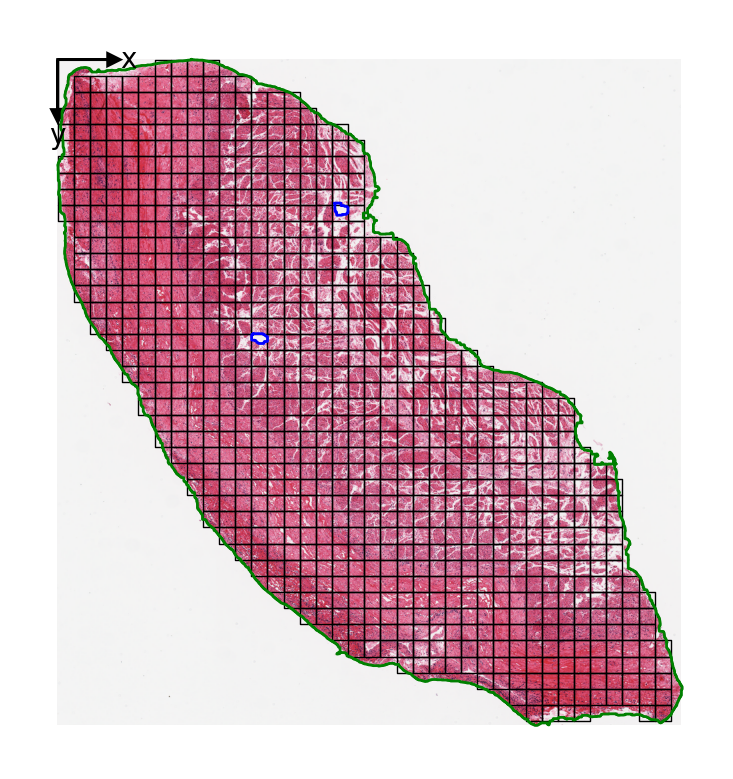

In [22]:
zs.pl.tiles(wsi, tissue_id=0, show_grid=True, show_point=False)

In [23]:
zs.pp.tiles_qc(wsi, scorers=["contrast", "focus"], num_workers=4)

Output()

In [24]:
wsi['tiles']

id      x      y  tissue_id  \
0        0   3448  27085          0   
1        1   3448  27341          0   
2        2   3448  27853          0   
3        3   3448  28109          0   
4        4   3448  28365          0   
...    ...    ...    ...        ...   
4309  4309  43933   8960          5   
4310  4310  44189   7680          5   
4311  4311  44189   7936          5   
4312  4312  44189   8192          5   
4313  4313  44189   8448          5   

                                               geometry  contrast     focus  \
0     POLYGON ((3704 27085, 3704 27341, 3448 27341, ...  0.835294  0.000000   
1     POLYGON ((3704 27341, 3704 27597, 3448 27597, ...  0.823529  0.262961   
2     POLYGON ((3704 27853, 3704 28109, 3448 28109, ...  0.815686  0.000000   
3     POLYGON ((3704 28109, 3704 28365, 3448 28365, ...  0.843137  0.000000   
4     POLYGON ((3704 28365, 3704 28621, 3448 28621, ...  0.827451  0.000000   
...                                                 ...       ...       ...   
4309  POLYGON ((44189 8960, 44189 9216, 43933 9216, ...  0.788235  0.000000   
4310  POLYGON ((44445 7680, 44445 7936, 44189 7936, ...  0.811765  0.000000   
4311  POLYGON ((44445 7936, 44445 8192, 44189 8192, ...  0.811765  0.000000   
4312  POLYGON ((44445 8192, 44445 8448, 44189 8448, ...  0.854902  0.000000   
4313  POLYGON ((44445 8448, 44445 8704, 44189 8704, ...  0.803922  0.000000   

        qc  
0     True  
1     True  
2     True  
3     True  
4     True  
...    ...  
4309  True  
4310  True  
4311  True  
4312  True  
4313  True  

[4314 rows x 8 columns]

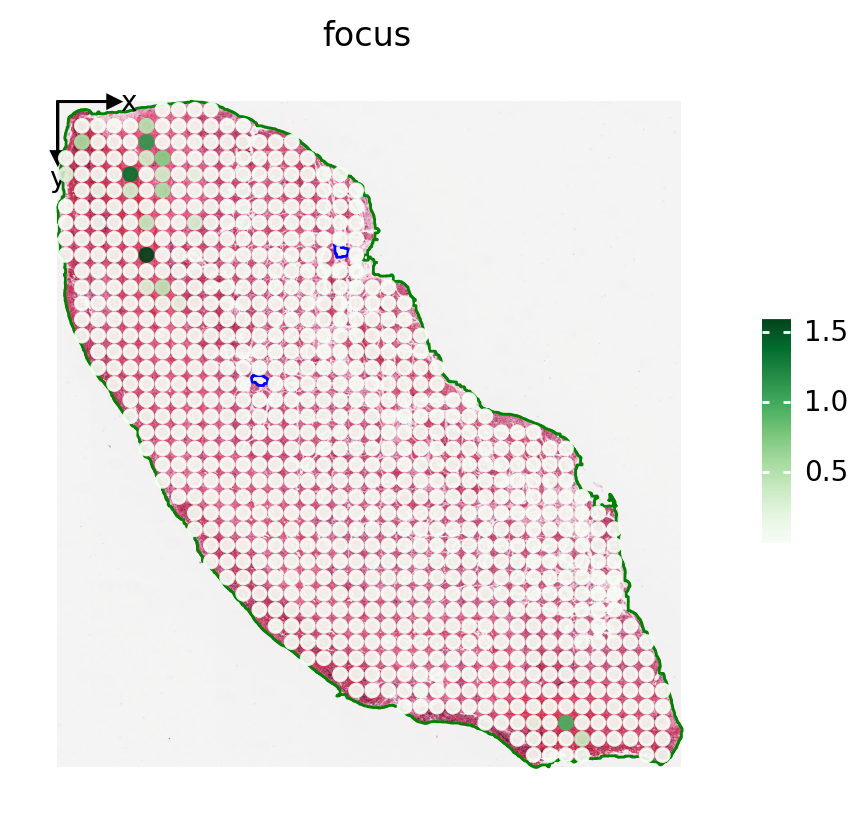

In [25]:
zs.pl.tiles(wsi, tissue_id=0, color='focus', cmap="Greens")

## Feature extraction

Feature extraction is to transform the image into a the numeric representation, which comprises of different morphological features. 

Typically, this is done by feeding the tiles into a vision model.

In [26]:
zs.tl.feature_extraction(wsi, 'resnet50', device="mps")

Output()

### Feature aggregation

To perform analysis across dataset, we need to create slide-level or tissue-level features.

In [27]:
zs.tl.feature_aggregation(wsi, 'resnet50', by="slide")
zs.tl.feature_aggregation(wsi, 'resnet50', by="tissue_id")

In [28]:
wsi['resnet50_tiles']

AnnData object with n_obs × n_vars = 4314 × 1000
    obs: 'tile_id', 'library_id', 'tissue_id'
    uns: 'spatialdata_attrs', 'agg_ops'
    varm: 'agg_slide', 'agg_tissue_id'

In [29]:
wsi.get.features_anndata('resnet50')

AnnData object with n_obs × n_vars = 4314 × 1000
    obs: 'id', 'x', 'y', 'tissue_id', 'contrast', 'focus', 'qc'
    uns: 'tile_spec', 'slide_properties'
    obsm: 'spatial'
    varm: 'agg_slide', 'agg_tissue_id'

## Save on the disk

In [30]:
wsi.save()

Notice that after saving, your `SpatialData` is now associated with a disk storage.

In [31]:
wsi

WSI: GTEX-1117F-1626
Reader: tiffslide
SpatialData object, with associated Zarr store: /Users/yzheng/Projects/LazySlide/docs/source/tutorial/GTEX-1117F-1626.zarr
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1439, 1696)
├── Shapes
│     ├── 'tiles': GeoDataFrame shape: (4314, 8) (2D shapes)
│     └── 'tissues': GeoDataFrame shape: (6, 54) (2D shapes)
└── Tables
      ├── 'resnet50_tiles': AnnData (4314, 1000)
      ├── 'slide_properties': AnnData (0, 0)
      └── 'tile_spec': AnnData (0, 0)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tiles (Shapes), tissues (Shapes)